## Pre-processing CellRanger outputs (multiple samples)

This notebook demonstrates the pipeline for processing scRNA-seq data, covering metric computation, normalization, clustering, cell type prediction, and the identification/removal of doublets and low-quality clusters. The final output is pre-processed, annotated scRNA-seq data.

In [1]:
import piaso
import cosg

/home/vas744/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import logging
from matplotlib import rcParams
import warnings

# To modify the default figure size, use rcParams.
rcParams['figure.figsize'] = 4, 4
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

This dataset was obtained from a mouse at E18 and includes various samples derived from different sequencing technologies, tissue types, and cell vs. nuclei preparations. 

The data was obtained from 10x Genomics: https://www.10xgenomics.com/datasets?configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000&refinementList%5Bproduct.name%5D%5B0%5D=Universal%203%27%20Gene%20Expression&refinementList%5Bproduct.name%5D%5B1%5D=Flex%20Gene%20Expression&refinementList%5Bchemistry.version%5D%5B0%5D=3&refinementList%5Bchemistry.version%5D%5B1%5D=3.1&refinementList%5Bchemistry.version%5D%5B2%5D=4&refinementList%5Bspecies%5D%5B0%5D=Mouse&refinementList%5BanatomicalEntities%5D%5B0%5D=Brain&refinementList%5BanatomicalEntities%5D%5B1%5D=cortex&refinementList%5BanatomicalEntities%5D%5B2%5D=hippocampus

In [4]:
!/home/vas744/Software/gdrive files download --overwrite --recursive --destination /n/scratch/users/v/vas744/Data/Public/PIASO/multiple_samples 1fOVhYBDQirFtrpRPuy7euAHykXuTSe_r

Found 3 files in 1 directories with a total size of 129.2 MB
Creating directory E18_h5_files
Downloaded 3 files in 1 directories with a total size of 129.2 MB


For this tutorial, we will use only three samples from this dataset. The selection includes one sample from cells, one from nuclei, and one from a different version of 10x (GEM-X-v4), providing a diverse range of sample types within a limited dataset.

In [4]:
data_path='/n/scratch/users/v/vas744/Data/Public/PIASO/multiple_samples/'
time_points = [entry.name for entry in os.scandir(data_path) if entry.is_dir()]
print(time_points)

for time_point in time_points:
    samples = [entry.name for entry in os.scandir(data_path+time_point) if entry.is_dir()]
    print(time_point, samples)

['E18']
E18 ['E18_v3.1_cell', 'E18_v3.1_nuclei', 'E18_v4_cell']


We will use this function to load multiple .h5 files into adata objects, creating a list of adata objects.

In [5]:
def load_multiple_anndata(
    data_path,
    time_points,
    key_added):
    anndata_list = []
    for time_point in time_points:
        samples = [entry.name for entry in os.scandir(data_path+time_point) if entry.is_dir()]
        for sample in samples:
            try:
                # Load the data
                file_name = os.listdir(data_path+time_point+'/'+sample)[0]
                h5_path=data_path+time_point+'/'+sample+'/'+file_name
                if os.path.exists(h5_path):
                    adata = sc.read_10x_h5(h5_path)
                    print('Loading the h5 file')
                    
                else:
                    adata = sc.read_10x_mtx(data_path+'/'+sample, cache=True)
                adata.var_names_make_unique()
                adata.obs_names_make_unique()
                adata.obs[key_added]=sample
                anndata_list.append(adata)
                print('Sample loaded: ', sample)
            except Exception as e:
                print(f"Error loading {data_path}: {e}")

    return anndata_list

In [6]:
adata_list=load_multiple_anndata(data_path=data_path, time_points=time_points, key_added='Sample')

reading /n/scratch/users/v/vas744/Data/Public/PIASO/multiple_samples/E18/E18_v3.1_cell/neuron_10k_v3_filtered_feature_bc_matrix.h5
 (0:00:02)


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loading the h5 file
Sample loaded:  E18_v3.1_cell
reading /n/scratch/users/v/vas744/Data/Public/PIASO/multiple_samples/E18/E18_v3.1_nuclei/SC3_v3_NextGem_DI_Nuclei_5K_SC3_v3_NextGem_DI_Nuclei_5K_count_sample_feature_bc_matrix.h5


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loading the h5 file
Sample loaded:  E18_v3.1_nuclei
reading /n/scratch/users/v/vas744/Data/Public/PIASO/multiple_samples/E18/E18_v4_cell/10k_Mouse_Neurons_3p_gemx_10k_Mouse_Neurons_3p_gemx_count_sample_filtered_feature_bc_matrix.h5


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loading the h5 file
Sample loaded:  E18_v4_cell


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Concatenate the adata objects in the list to create a single adata object that contains information from all the samples and time points.

In [7]:
adata=ad.concat(adata_list, join='outer',index_unique="-")

In [8]:
adata

AnnData object with n_obs × n_vars = 30257 × 37089
    obs: 'Sample'

In [9]:
adata.layers['raw']=adata.X.copy()

In [10]:
adata.var_names_make_unique()

Next, we filter out cells with fewer than 200 detected genes.

In [11]:
sc.pp.filter_cells(adata, min_genes=200)

filtered out 386 cells that have less than 200 genes expressed


We identify mitochondrial and ribosomal protein genes and compute their proportion in each cell’s total read count. A high proportion of these reads often indicates low-quality cells.

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [13]:
ribo_cells = adata.var_names.str.startswith('Rps','Rpl')
adata.obs['pct_counts_ribo'] = np.ravel(100*np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1))

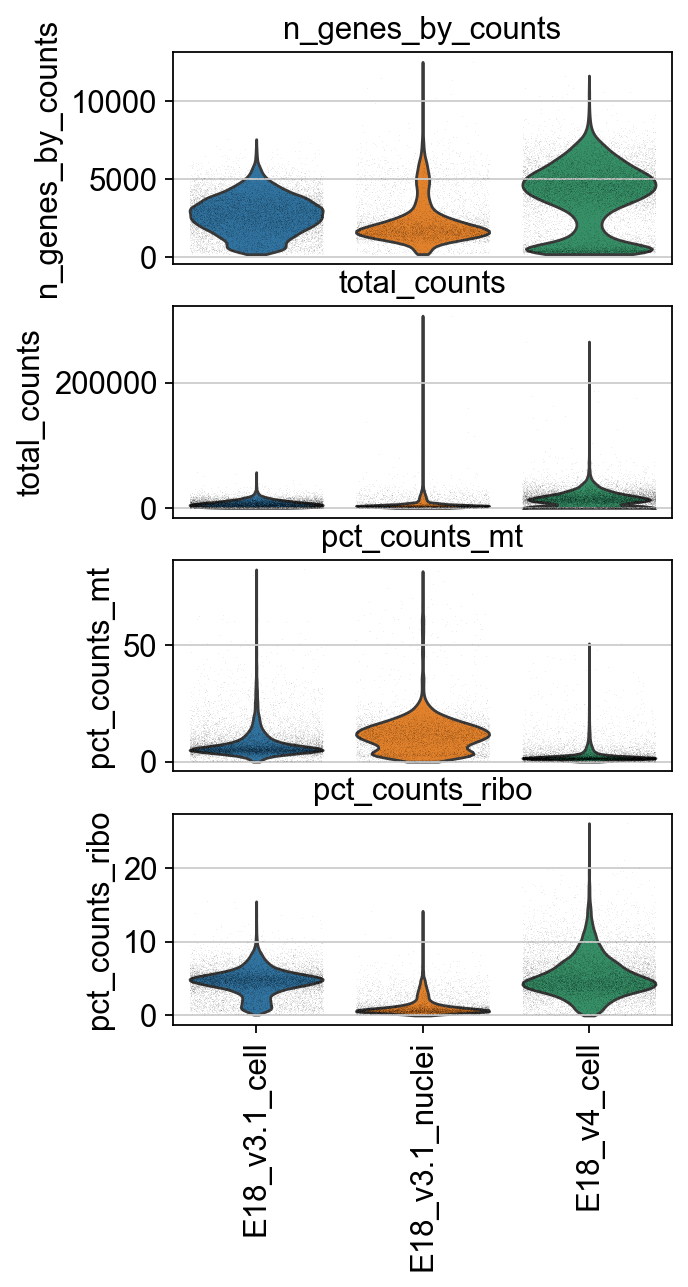

In [14]:
piaso.pl.plot_features_violin(adata,
                              ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
                              width_single=4,
                              groupby='Sample')

### Doublet prediction

Next, we compute the Scrublet score to identify and predict potential doublets.

In [15]:
experiments=np.unique(adata.obs['Sample'])
adata.obs['scrublet_score']=np.repeat(0,adata.n_obs)
adata.obs['predicted_doublets']=np.repeat(False,adata.n_obs)

In [16]:
import scrublet as scr

for experiment in experiments:
    print(experiment)
    adatai=adata[adata.obs['Sample']==experiment]

    scrub = scr.Scrublet(adatai.X.todense(),random_state=10)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
    
    adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores    

E18_v3.1_cell
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 28.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.1%
Elapsed time: 32.3 seconds
E18_v3.1_nuclei


/tmp/ipykernel_17593/2312138584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
/tmp/ipykernel_17593/2312138584.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.3%
Elapsed time: 17.2 seconds
E18_v4_cell


/tmp/ipykernel_17593/2312138584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 65.7 seconds


/tmp/ipykernel_17593/2312138584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets


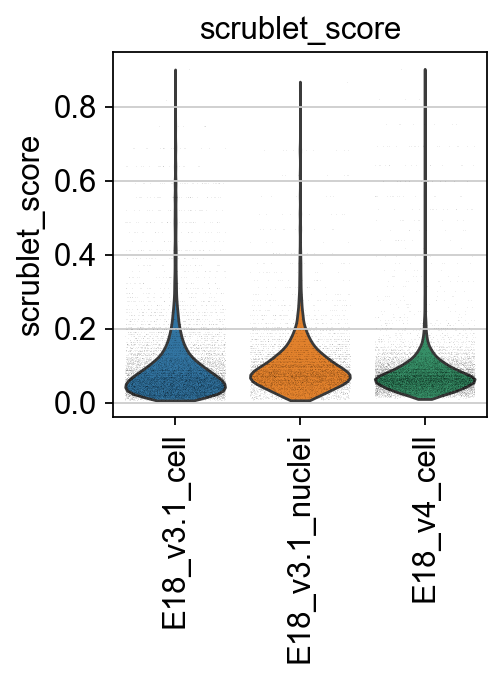

In [17]:
piaso.pl.plot_features_violin(adata,
                              ['scrublet_score'],
                              groupby='Sample',
                              width_single=3,
                              height_single=3)

In [18]:
tmp=np.repeat(False, adata.n_obs)
tmp[adata.obs['predicted_doublets'].values==True]=True
adata.obs['predicted_doublets']=tmp

In [19]:
print(f"# of cells with scrublet score >= 0.2: {np.sum(adata.obs['scrublet_score']>=0.2)} \n# of predicted doublets: {np.sum(adata.obs['predicted_doublets'])}")

# of cells with scrublet score >= 0.2: 1510 
# of predicted doublets: 373


### Normalization

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['log1p']=adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


### INFOG normalization

We use PIASO's infog to normalize the data and identify a highly variable set of genes.

In [21]:
%%time
piaso.tl.infog(adata,
               layer='raw',
               n_top_genes=3000,)

The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable` in `adata.var`.
Finished INFOG normalization.
CPU times: user 19 s, sys: 8.06 s, total: 27.1 s
Wall time: 27.1 s


### SVD dimensionality reduction and visualization

In [22]:
piaso.tl.runSVD(adata,
                use_highly_variable=True,
                n_components=50,
                random_state=10,
                key_added='X_svd',
                layer='infog')

In [23]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_svd',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")

sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:36)
CPU times: user 1min 30s, sys: 685 ms, total: 1min 30s
Wall time: 1min 16s


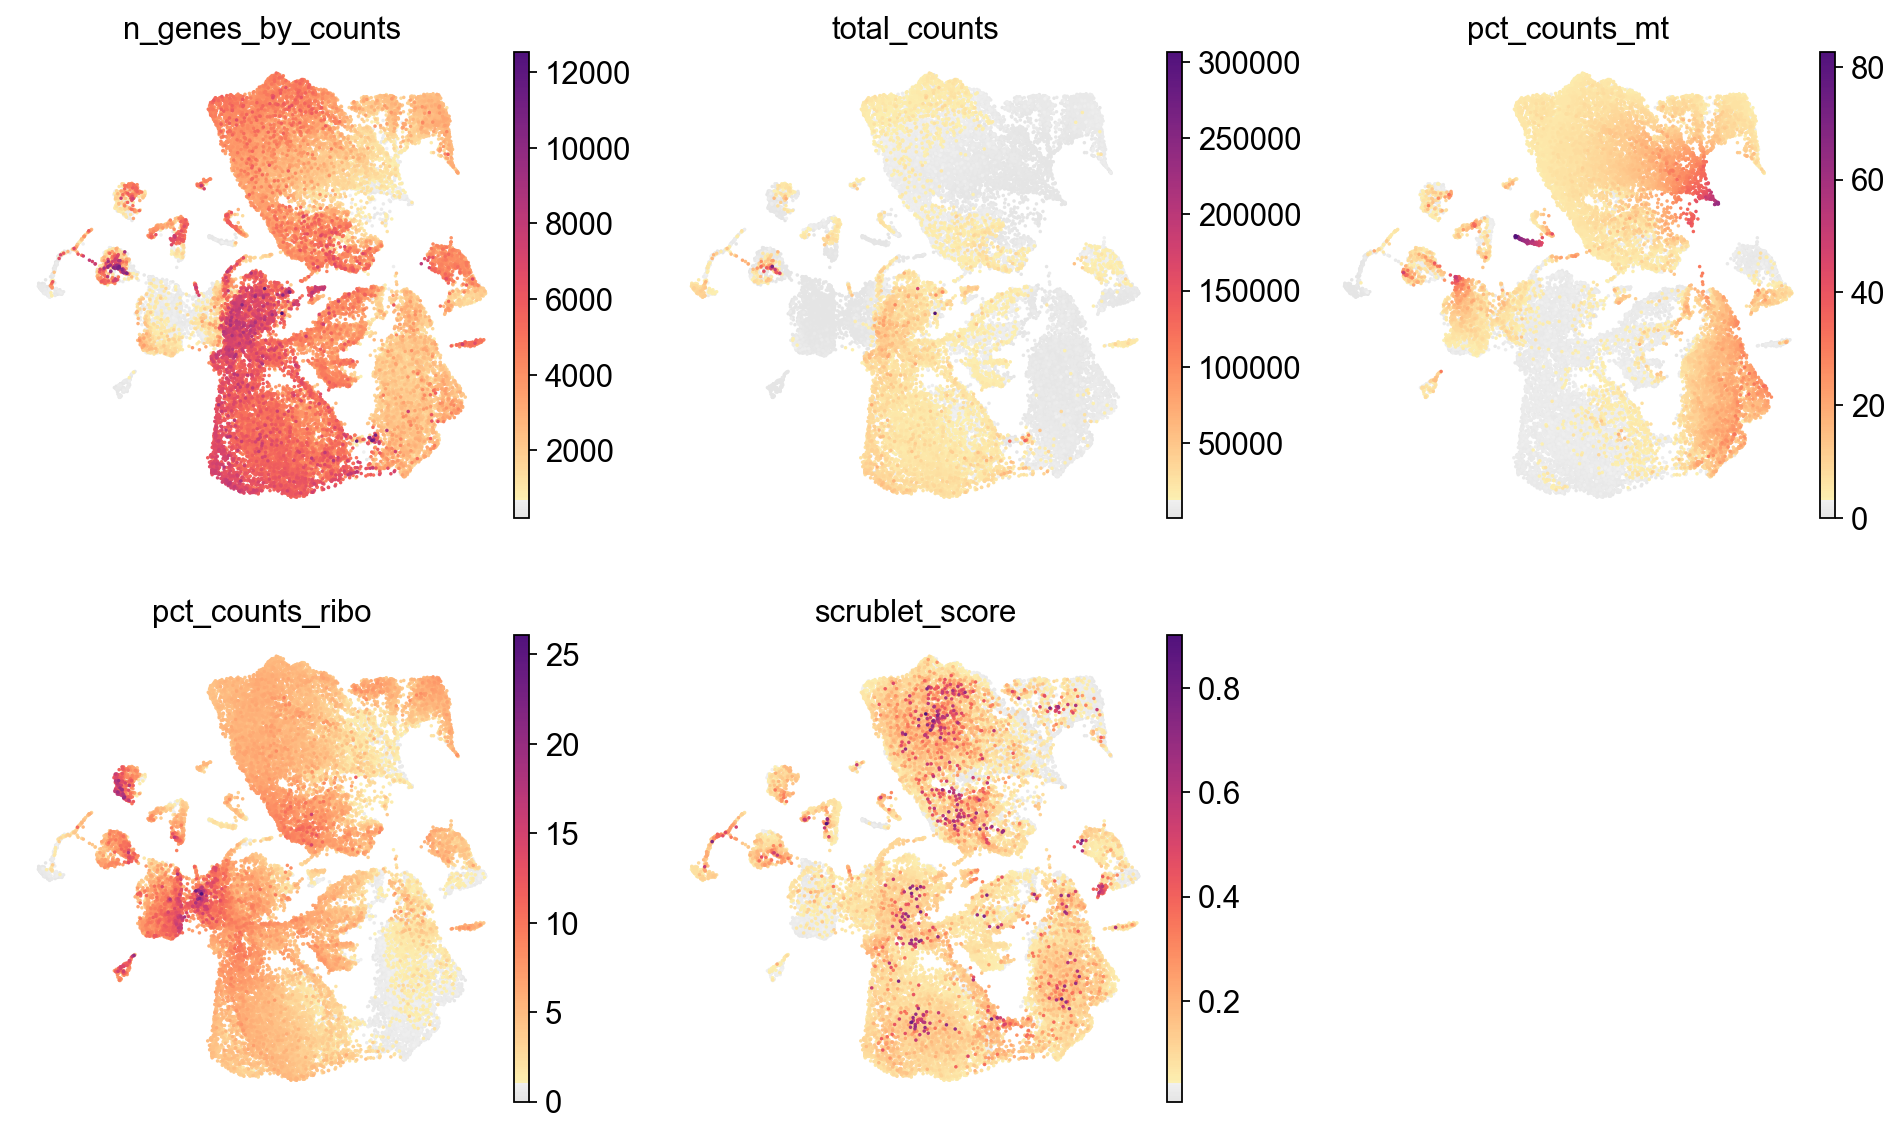

In [24]:
sc.pl.umap(adata,
           color=['n_genes_by_counts', 'total_counts','pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
           cmap=piaso.pl.color.c_color1,
           palette=piaso.pl.color.d_color1,
           ncols=3,
           size=10,
           frameon=False)

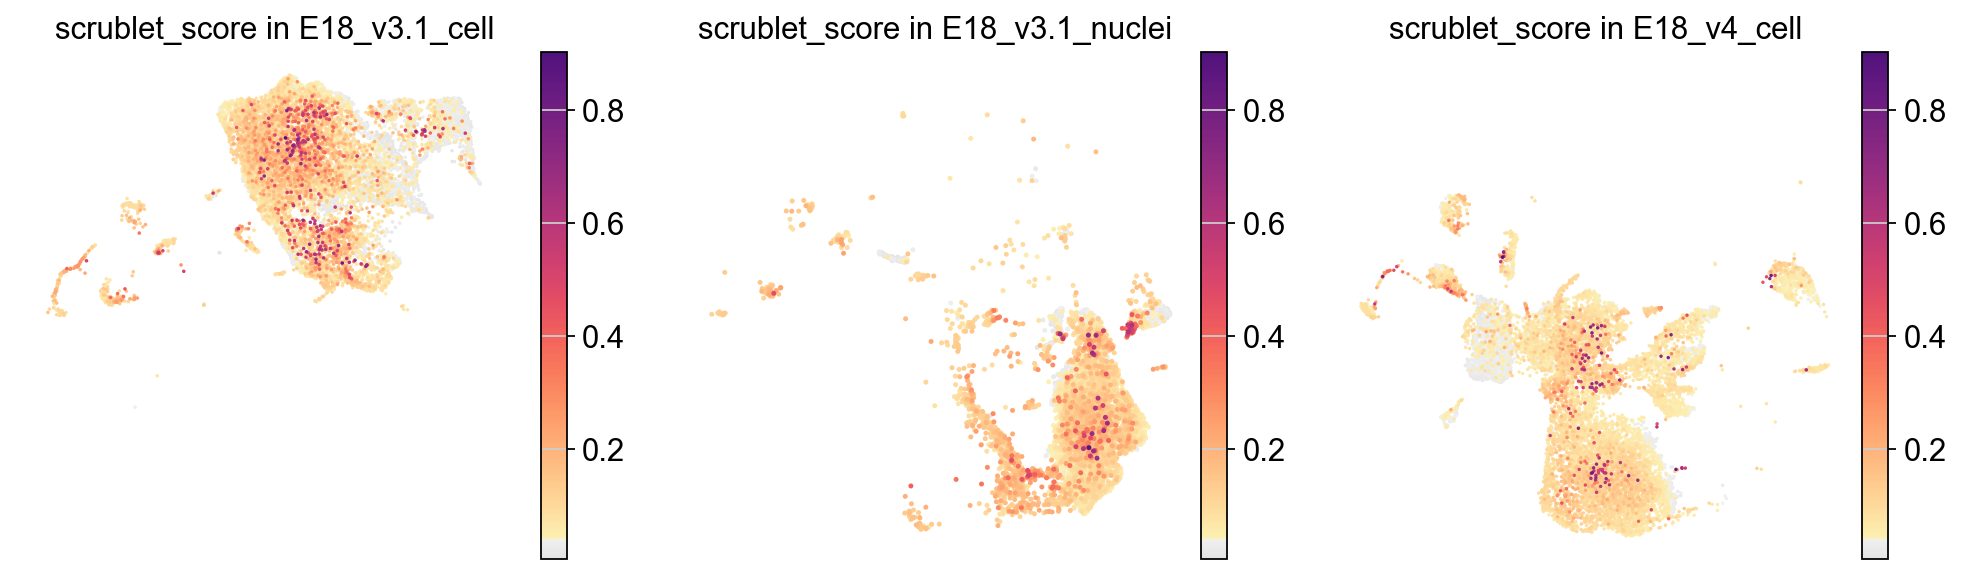

In [26]:
piaso.pl.plot_embeddings_split(adata,
                               color='scrublet_score',
                               cmap=piaso.pl.color.c_color1,
                               splitby='Sample',
                               ncol=3,
                               frameon=False)

### Leiden clustering

In [27]:
%%time
sc.tl.leiden(adata,resolution=0.5,key_added='Leiden')

running Leiden clustering
    finished: found 24 clusters and added
    'Leiden', the cluster labels (adata.obs, categorical) (0:00:03)
CPU times: user 3.85 s, sys: 114 ms, total: 3.96 s
Wall time: 3.96 s


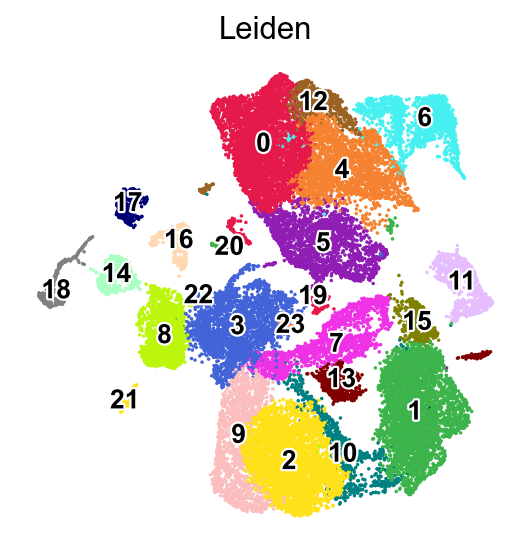

In [28]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

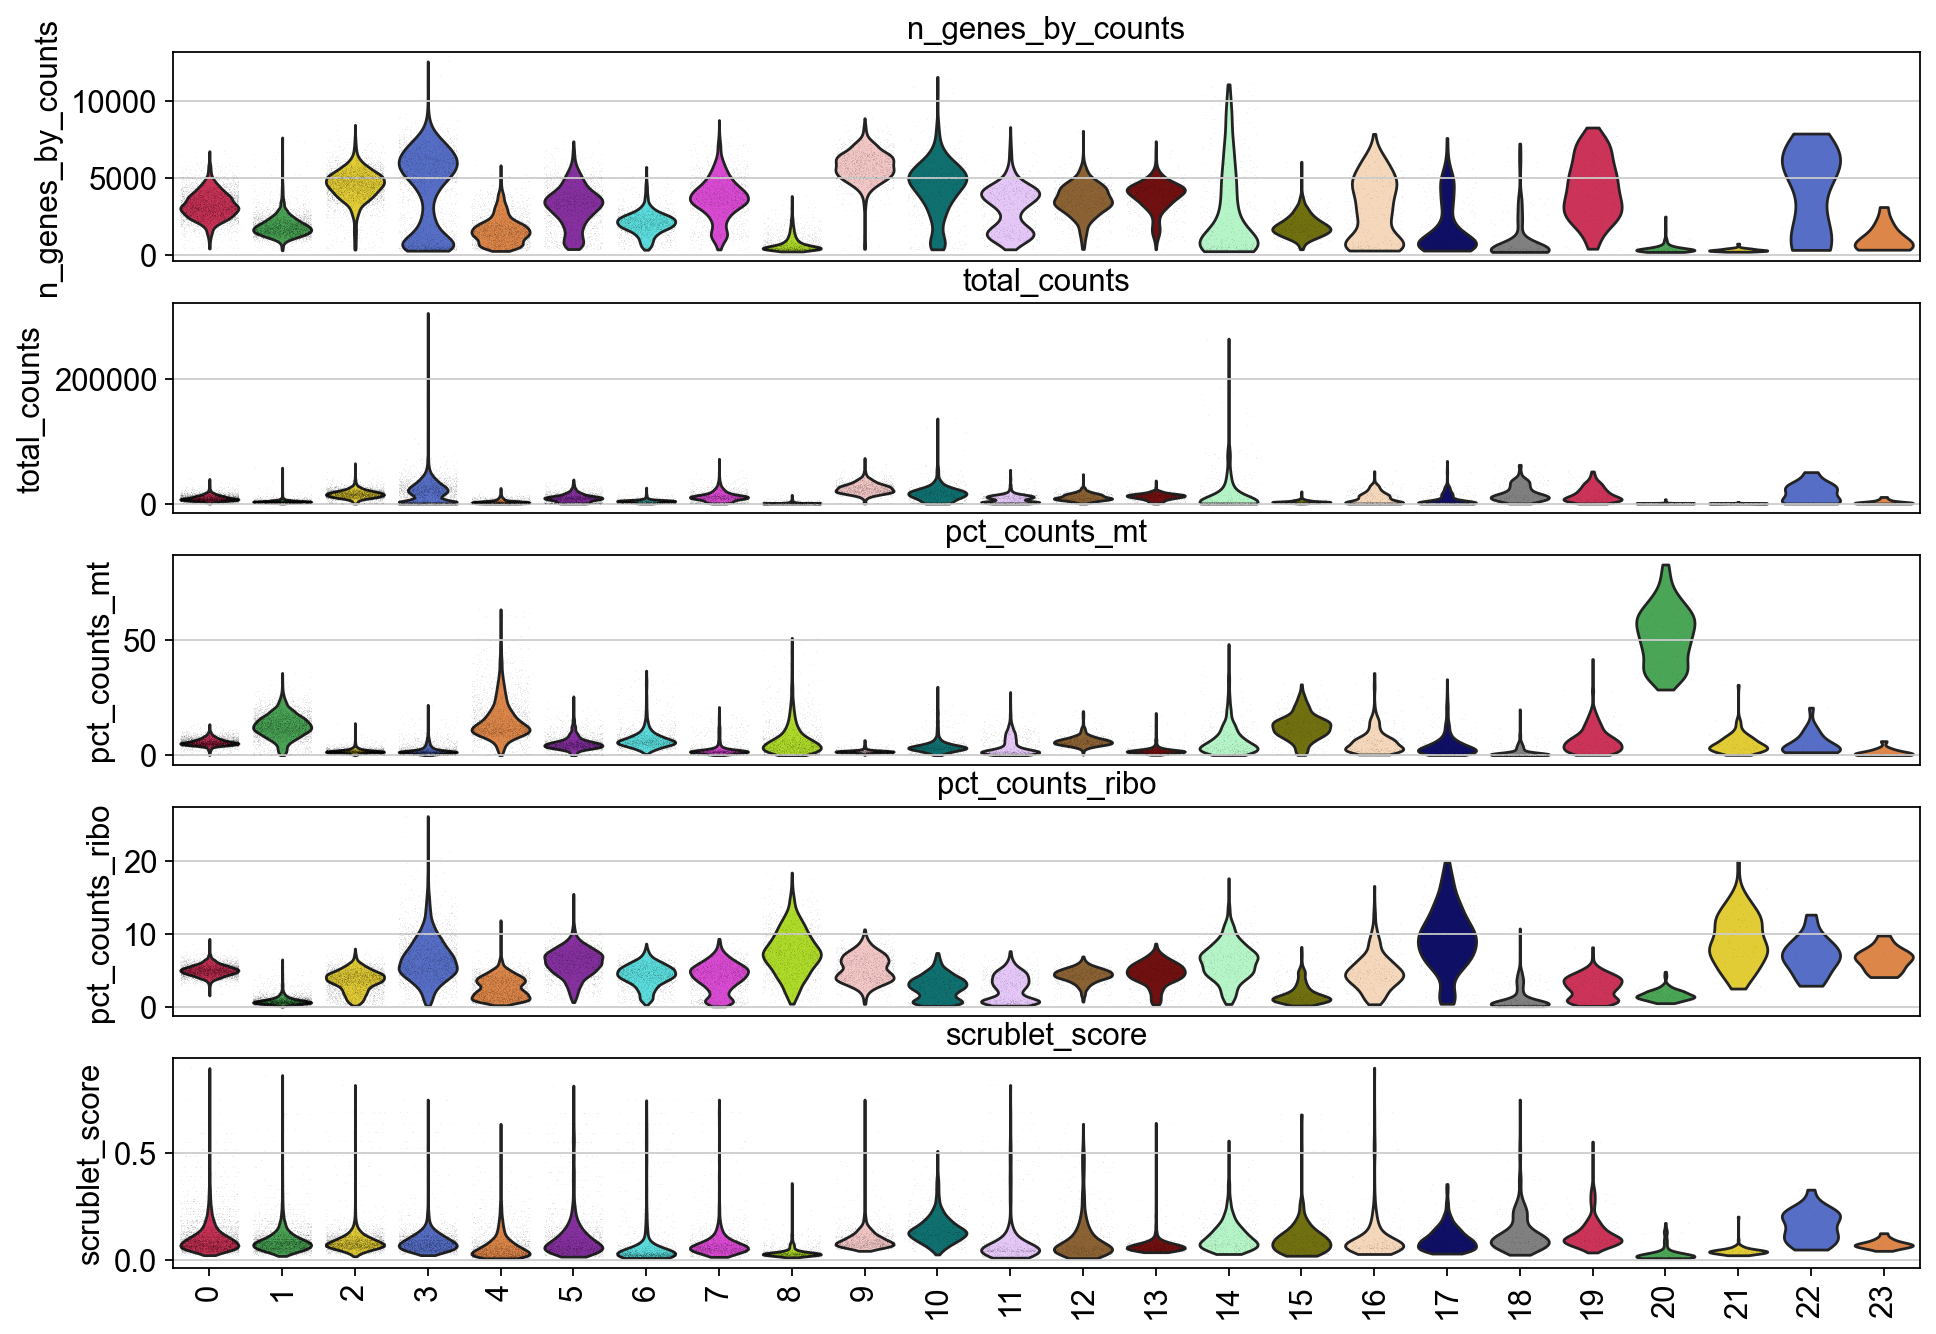

In [29]:
piaso.pl.plot_features_violin(adata,
                              ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
                              groupby='Leiden')

#### Identify marker genes with COSG

In [30]:
%%time
n_gene=30
cosg.cosg(adata,
          key_added='cosg',
          use_raw=False,
          layer='log1p',
          mu=100,
          expressed_pct=0.1,
          remove_lowly_expressed=True,
          n_genes_user=100,
          groupby='Leiden')

CPU times: user 6.57 s, sys: 2.75 s, total: 9.32 s
Wall time: 9.32 s


We can use a dendrogram dot plot to visualize the expression of the top three marker genes of each Leiden cluster.

Storing dendrogram info using `.uns['dendrogram_Leiden']`


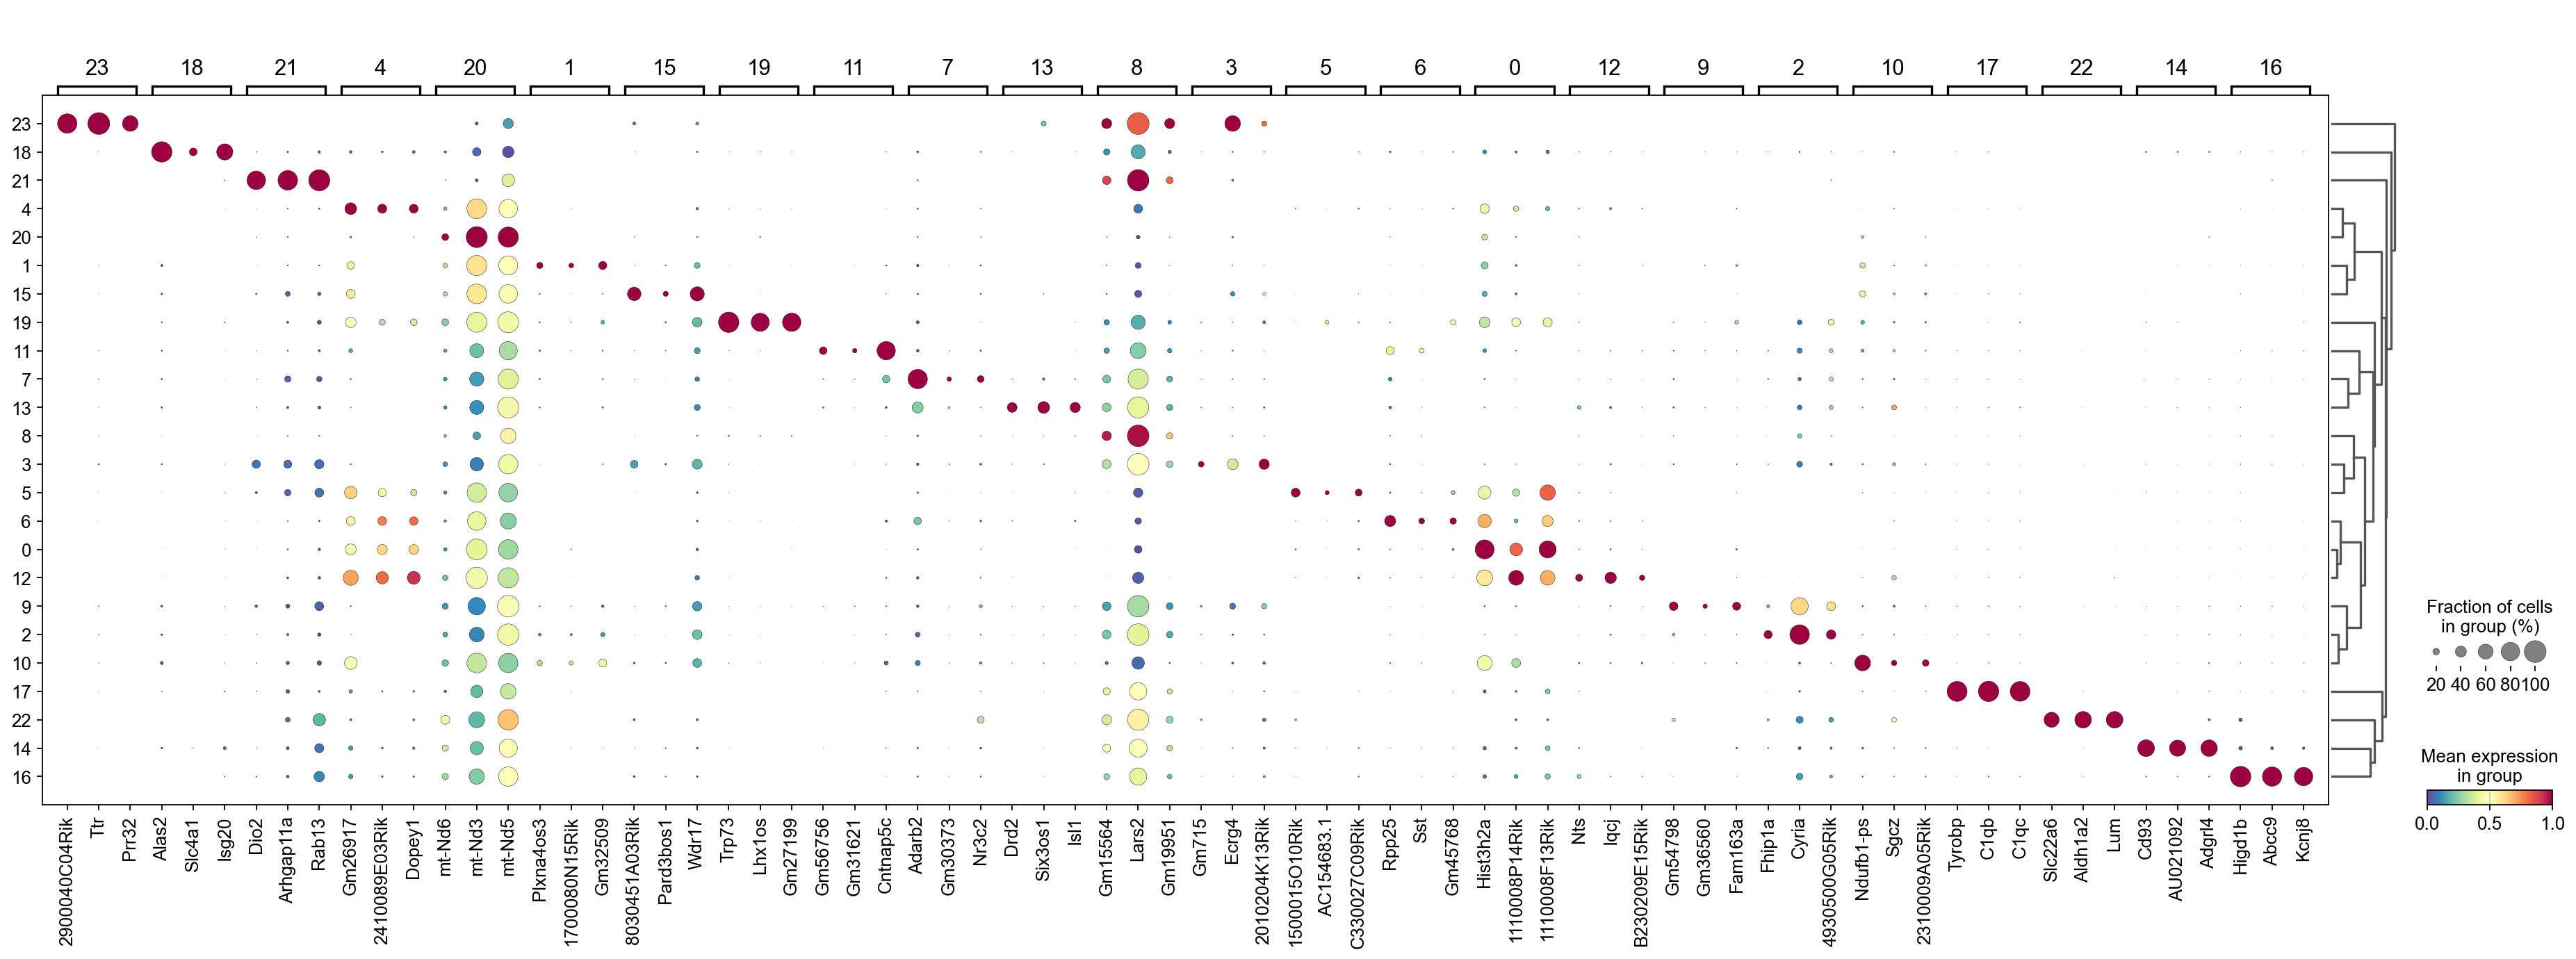

In [31]:
sc.tl.dendrogram(adata,groupby='Leiden',use_rep='X_svd')
df_tmp=pd.DataFrame(adata.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata.uns['dendrogram_'+'Leiden']['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}

sc.pl.dotplot(adata,
              marker_genes_list,
              groupby='Leiden',
              layer='log1p',
              dendrogram=True,
              swap_axes=False,
              standard_scale='var',
              cmap='Spectral_r')

Another way to visualize the expression of the top three marker genes from each Leiden cluster is by using COSG's plotMarkerDendrogram method to create a circular dendrogram.

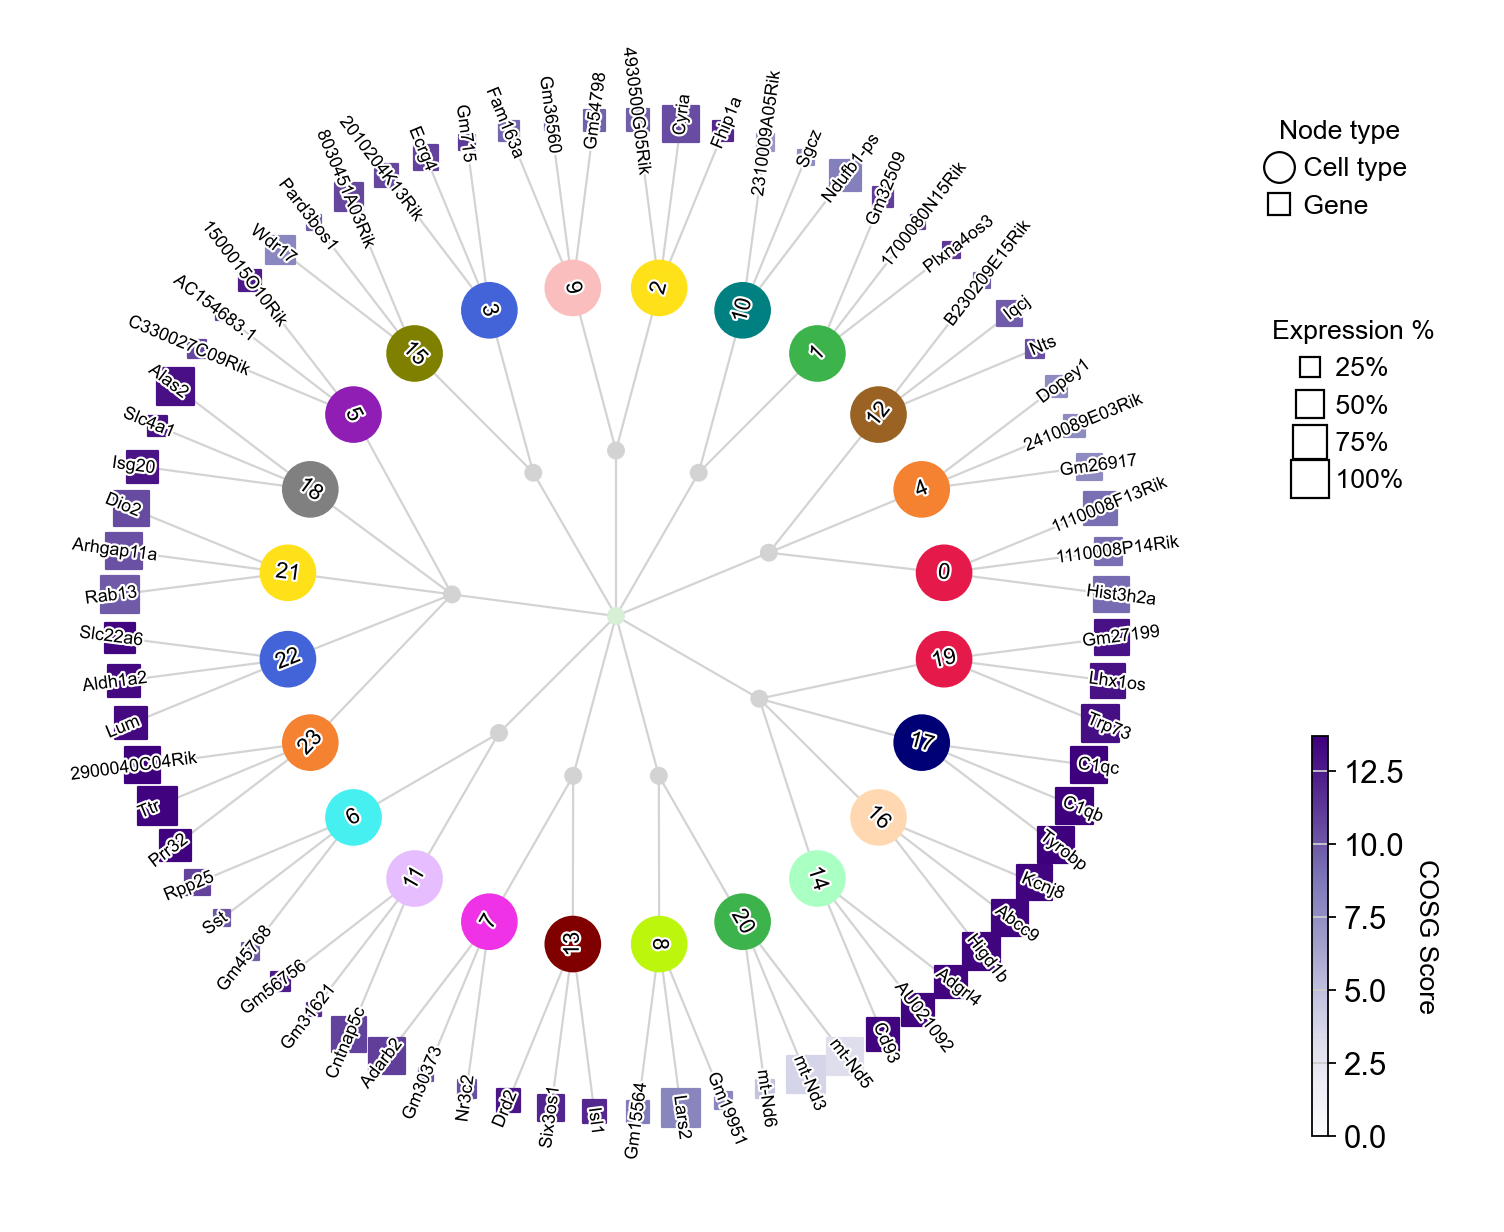

In [32]:
cosg.plotMarkerDendrogram(
     adata,
     group_by="Leiden",
     use_rep="X_svd",
     calculate_dendrogram_on_cosg_scores=True,
     top_n_genes=3,
     radius_step=4.5,
     cmap="Purples",
     gene_label_offset=0.25,
     gene_label_color="black",
     linkage_method="ward",
     distance_metric="correlation",
     hierarchy_merge_scale=0,
     collapse_scale=0.5,
     add_cluster_node_for_single_node_cluster=True,
     palette=None,
     figure_size= (10, 10),
     colorbar_width=0.01,
     gene_color_min=0,
     gene_color_max=None,
     show_figure=True,
)

### Marker genes of an individual cluster

We can use dotplots and UMAPs to visualize the expression of the top marker genes in a selected cluster, which can be used to evaluate cluster quality.

In [33]:
marker_gene=pd.DataFrame(adata.uns['cosg']['names'])

In [34]:
cluster_check='11'
marker_gene[cluster_check].values

array(['Gm56756', 'Gm31621', 'Cntnap5c', 'Dlgap2', 'Gm13986', 'Dpp10',
       'Nxph1', '4930555F03Rik', 'Gm2516', 'Gm45323', 'Epb41l4a', 'Chrm3',
       'Gm45341', 'Syndig1', 'Cntnap3', 'Kcnmb2', 'Ackr3', 'Sntg2', 'Mkx',
       'Cacng3', 'Nxph2', 'Gria4', 'Rbms3', 'Gria1', 'Nell1', 'Erbb4',
       'Tox2', 'Ror2', 'Greb1l', 'Neb', 'Neto1', 'Vat1l', 'C130073E24Rik',
       'Ptprt', 'Cntnap4', 'Kcns3', 'Amph', 'Maf', 'Dgkg', 'Gm47664',
       'Dpp6', 'Adamtsl1', 'Iqsec1', 'Fam135b', 'Dlx1as', 'Kcnc2', 'Lhx6',
       'Grm5', 'Gm38505', 'Dlgap1', 'Tafa5', 'Gabrg3', 'Rph3a', 'Pde4dip',
       'Edaradd', 'Gm20754', 'Fsip1', '4930415C11Rik', '4930509J09Rik',
       'Efcab6', 'Fgd3', 'Spats2l', 'Cdk14', 'Ptchd4', 'Ryr2', 'Gm14204',
       'Lhfpl3', 'Csrnp3', 'Sox1ot', 'Elfn1', 'Shisa6', 'Ripor2', 'Nrxn3',
       'Syt1', 'Rps6ka5', 'Grik1', 'Sox2ot', 'Gm26691', 'Xkr4', 'Tgfb3',
       'A330076H08Rik', 'Brinp3', 'Cbfa2t3', 'Fgf12', 'Bend4', 'Cdr1os',
       'Elmo1', 'Npy', 'Zfp536', 'Prickle2', '

The dot plot below displays the expression of the top marker genes from cluster 8 across all clusters. For cluster 8 to be considered high quality, its top marker genes should be primarily specific to cluster 8, showing little to no expression in other clusters.

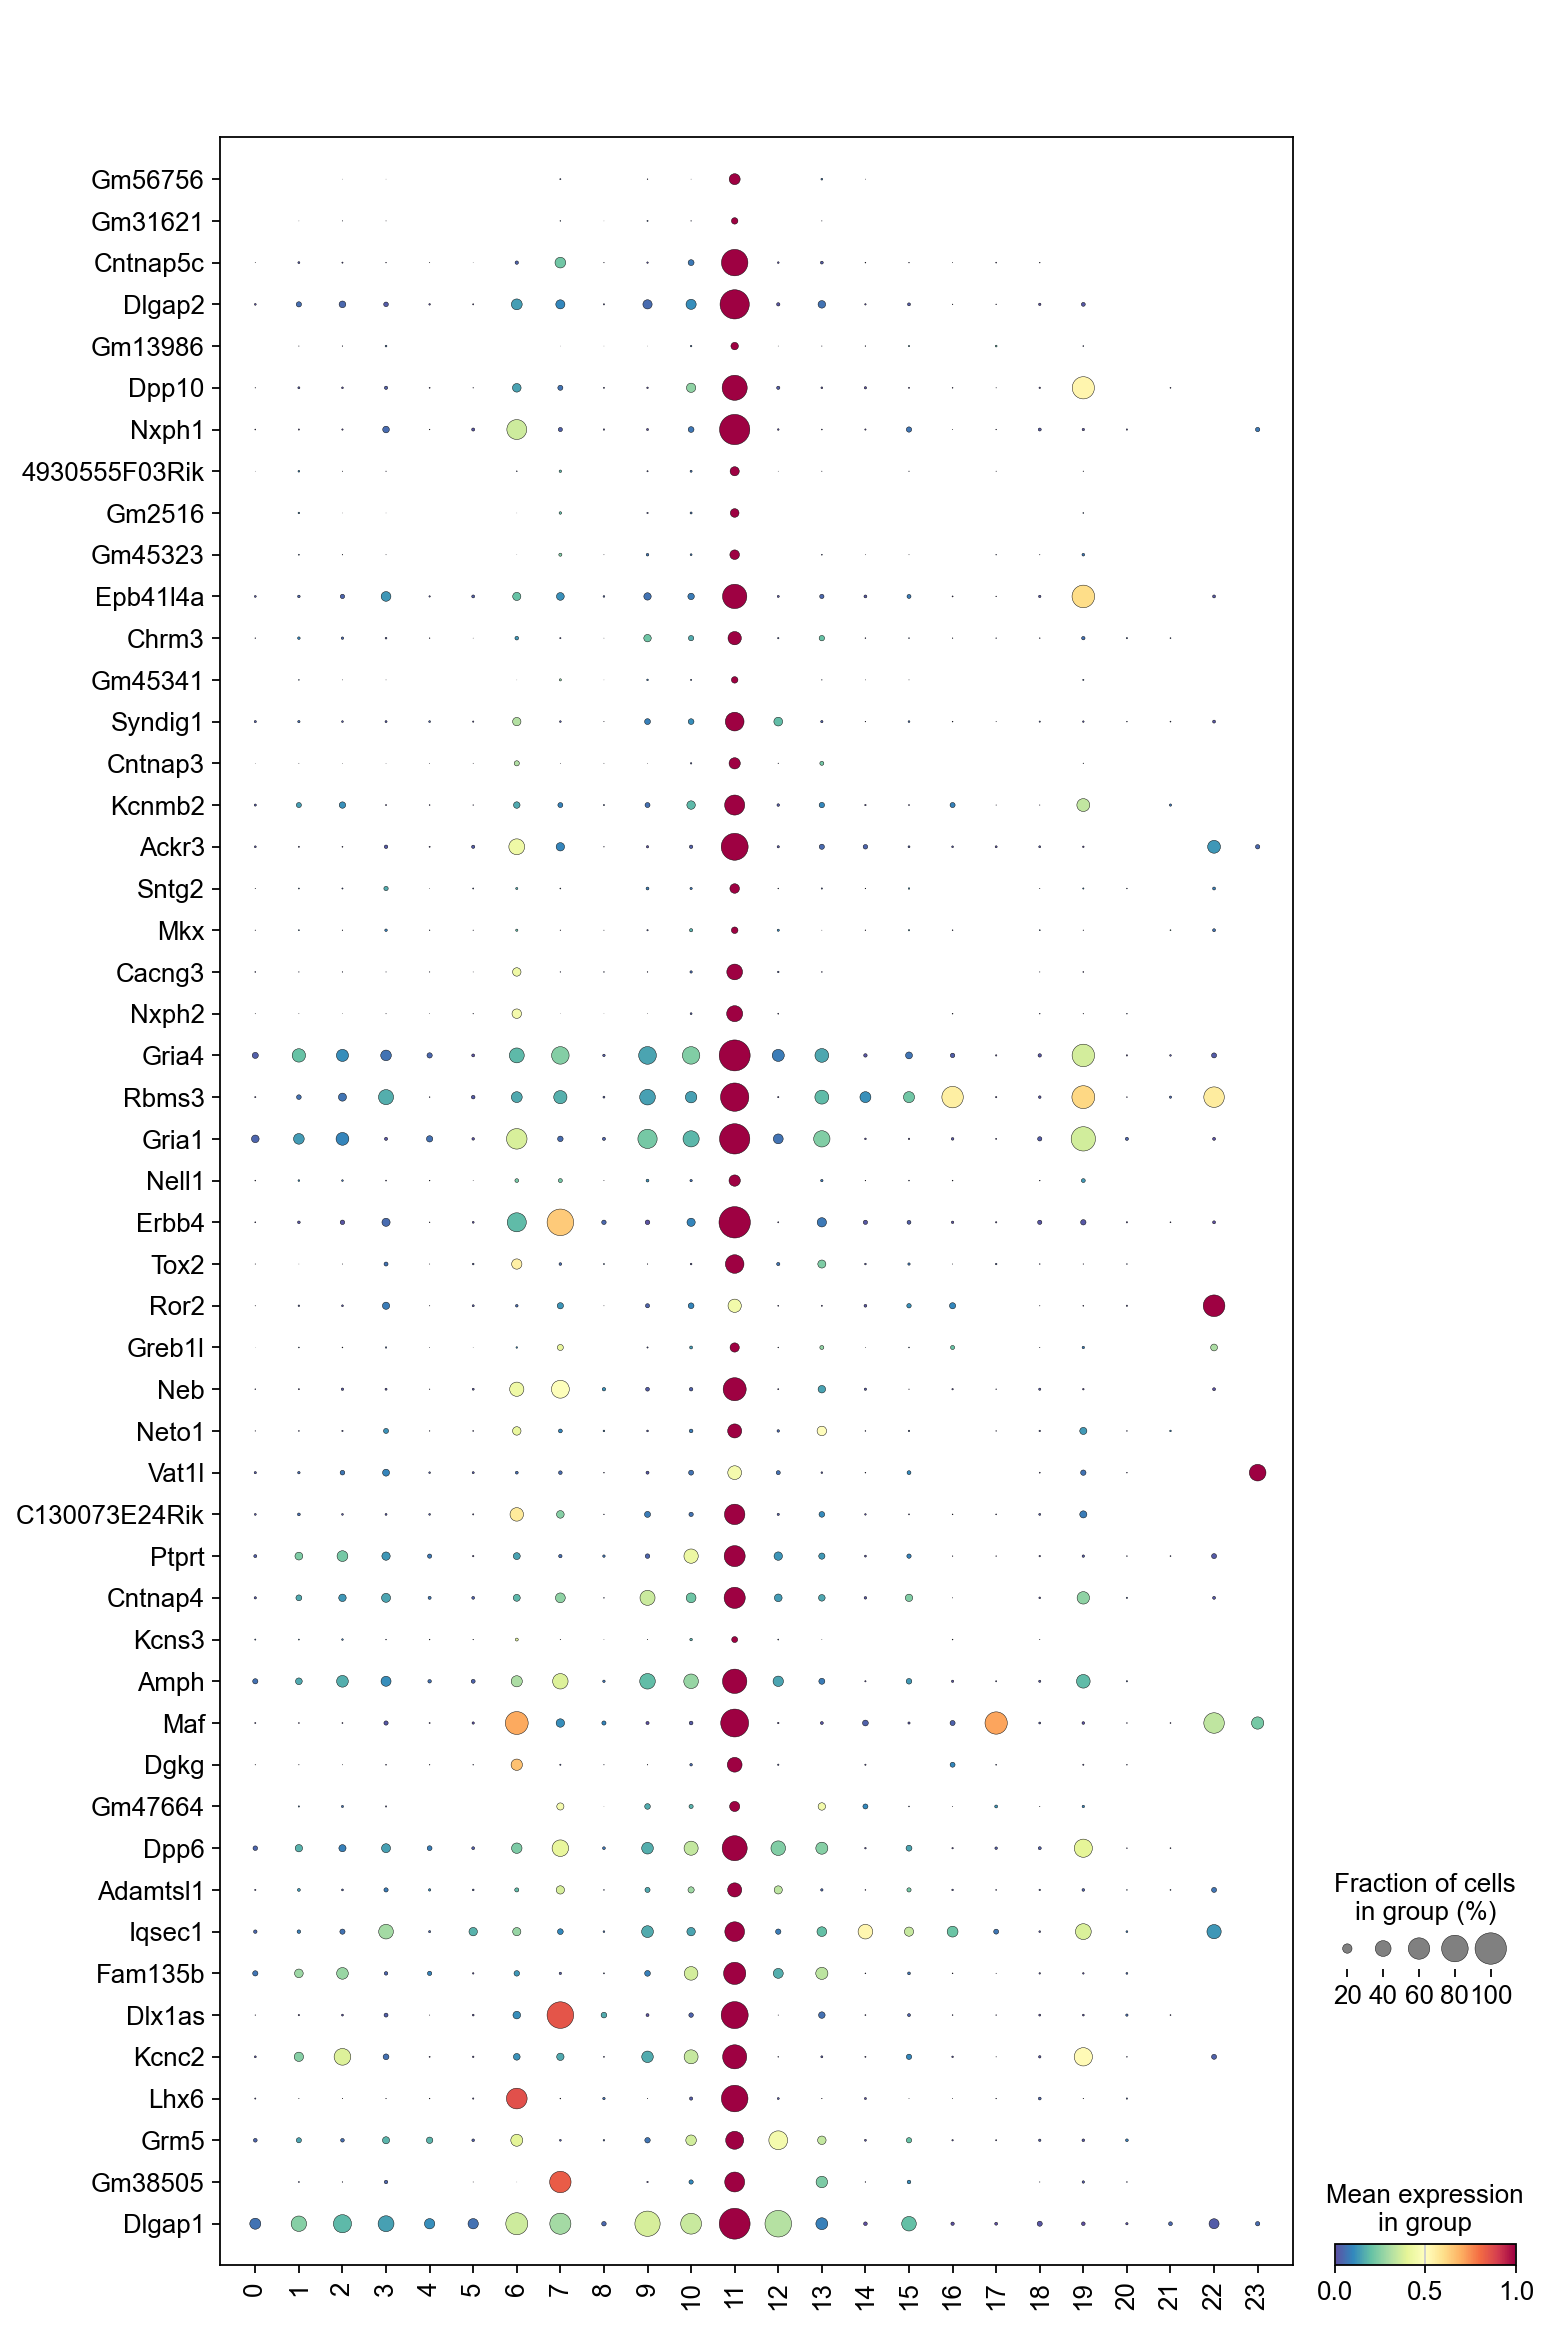

In [35]:
sc.pl.dotplot(adata,
              marker_gene[cluster_check].values[:50],
              groupby='Leiden',              
              dendrogram=False,
              swap_axes=True,
              standard_scale='var',
              cmap='Spectral_r')

We can visualize the expression of the top 12 genes from cluster 8 on UMAPs to assess whether their expression is specific to the cluster 8 region. This involves comparing the location of cluster 8 on the Leiden cluster UMAP with the gene expression UMAPs. In a high-quality cluster, marker gene expression should be predominantly localized to the cluster 8 area.

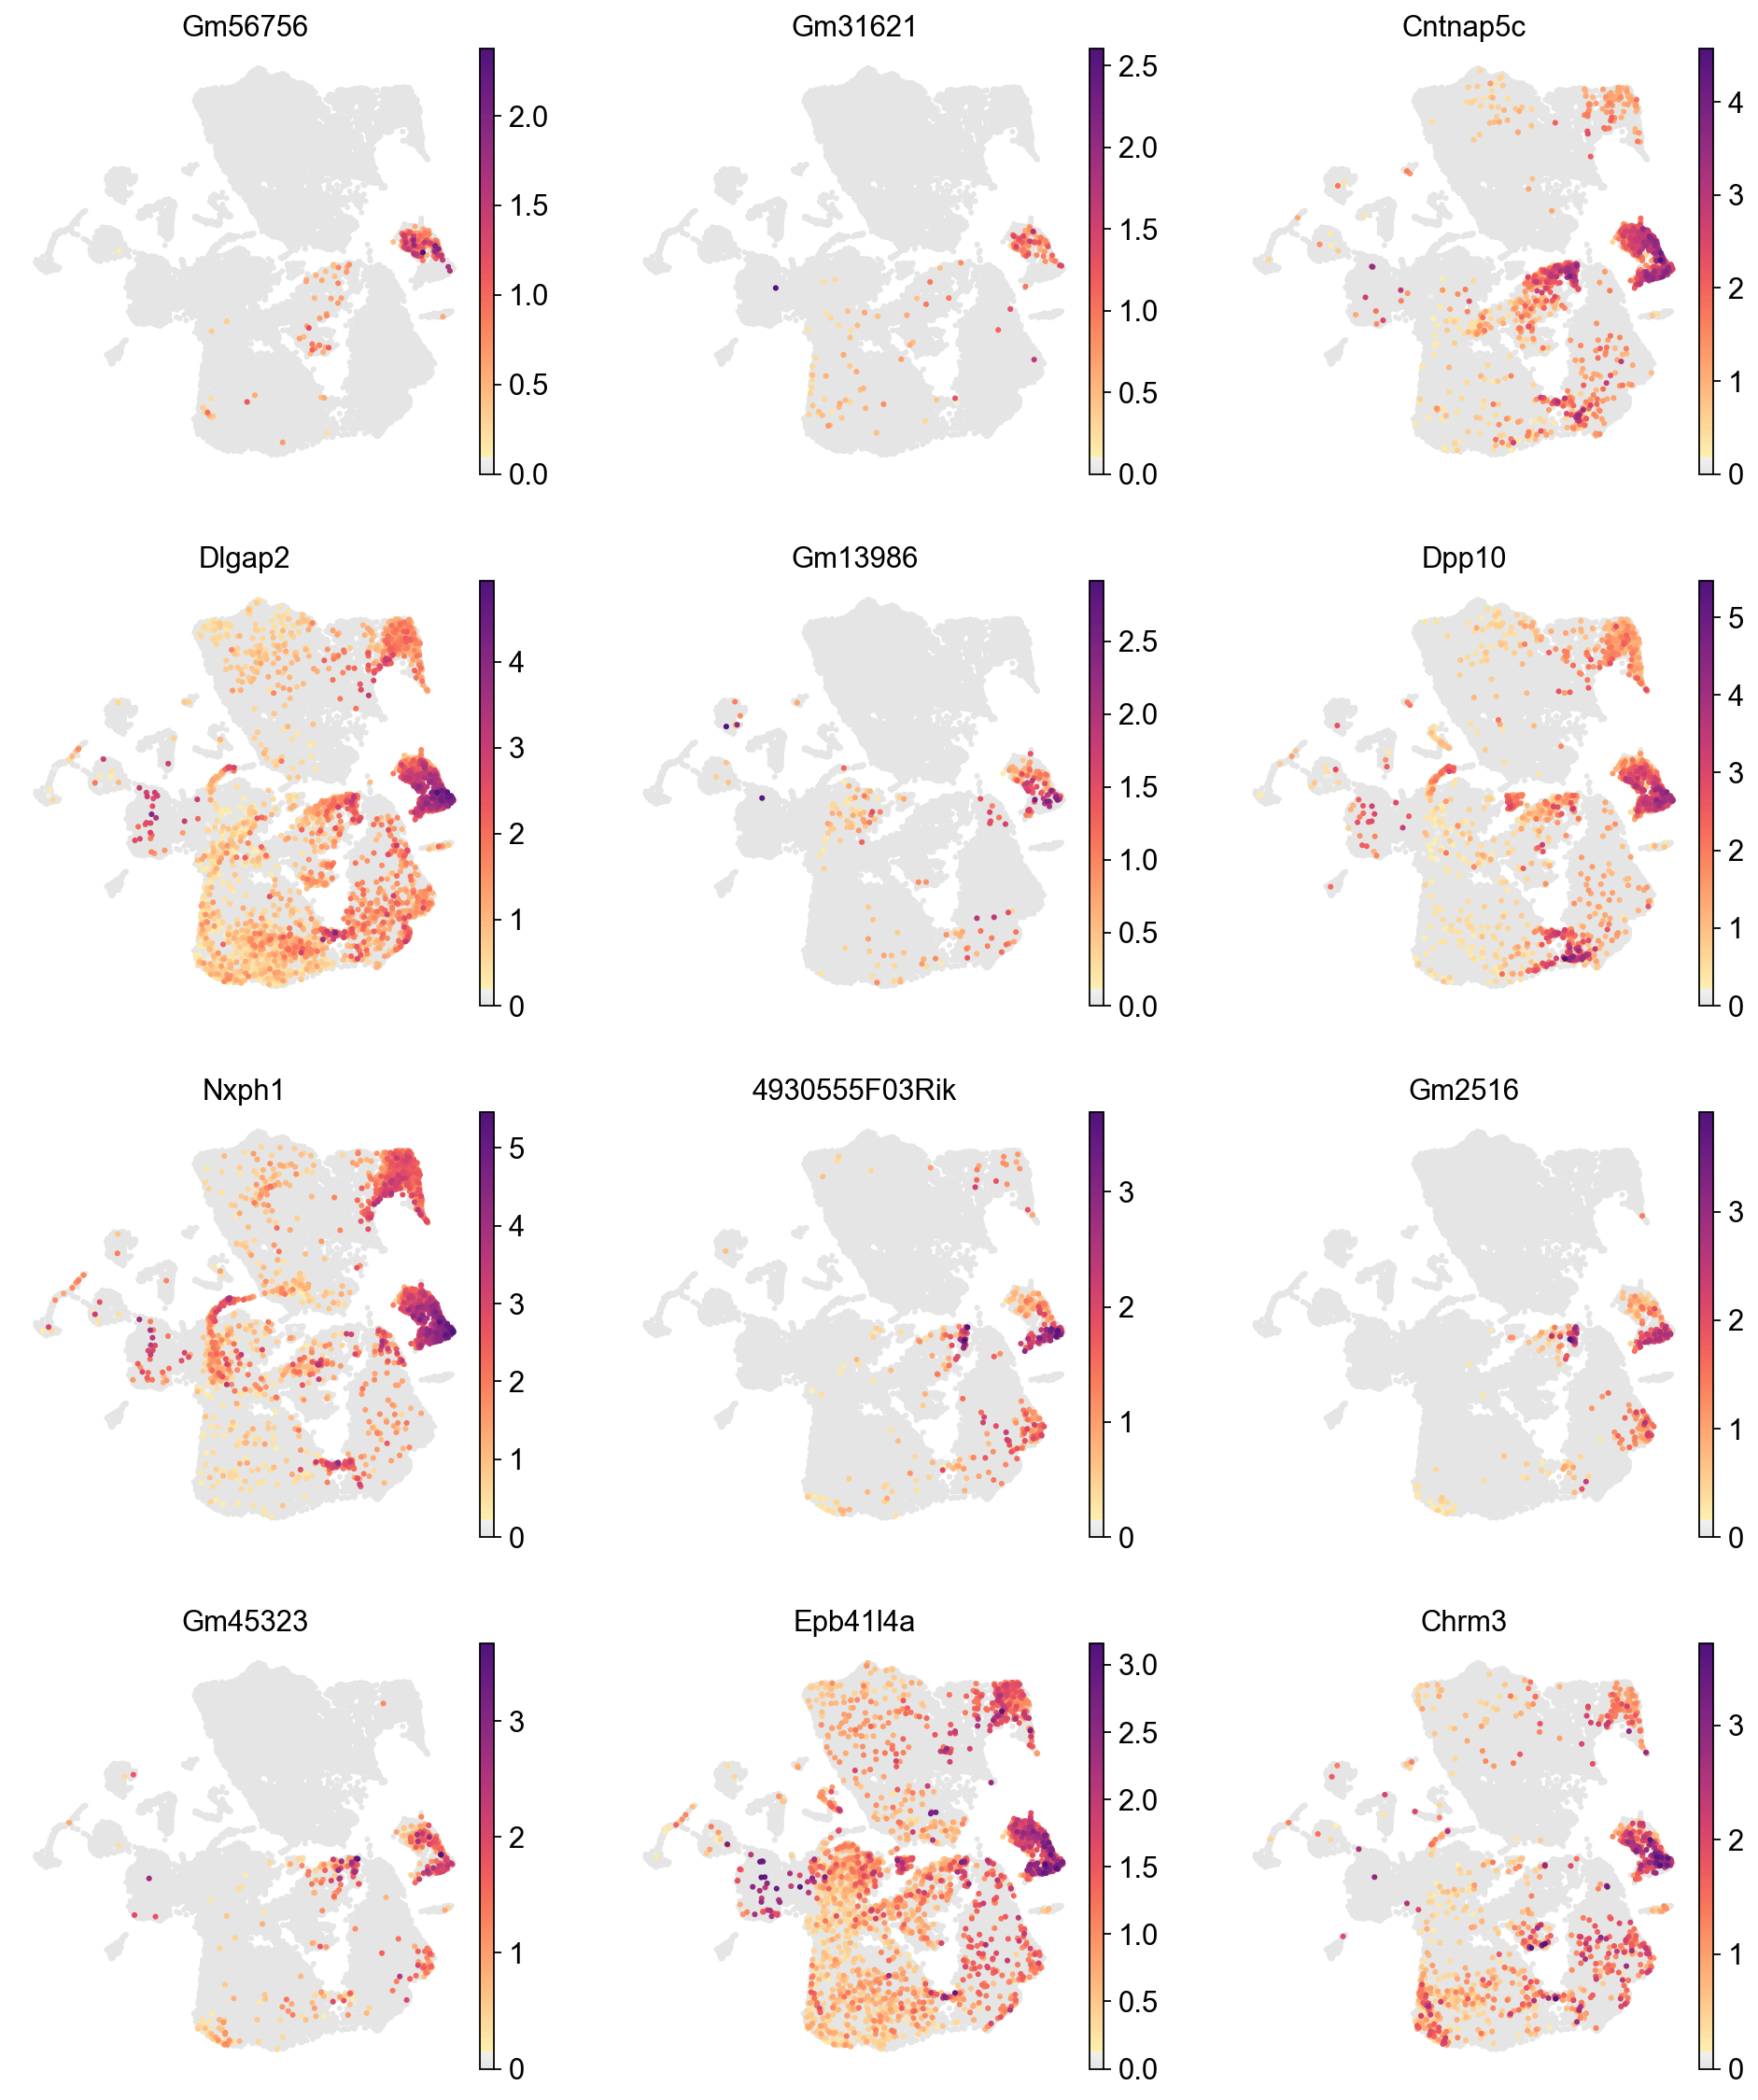

In [36]:
sc.pl.umap(adata,
           color=marker_gene[cluster_check][:12],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           layer='log1p',
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=3,
           size=30,
           frameon=False)

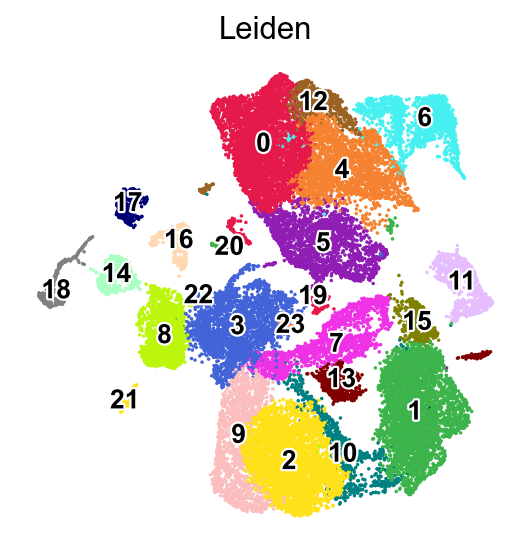

In [37]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

This pipeline is still in development. The next steps include using a reference dataset to annotate cell types with PIASO's predictCellTypesByGDR, followed by multiple iterations of low-quality cluster removal and re-clustering until well-defined clusters are obtained.